In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt 
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import alphalens as al
import pickle 
import warnings
import json

from functions.datareader import pull_stock_data, YFinanceReader
from functions.portfolio_optimizer import RiskModelPCA, OptimalHoldings, OptimalHoldingsStrictFactor
from functions.alpha_evaluator import AlphaFactorEvaluator
from functions.alpha_generator import NoOverlapClassifier
from functions.indicators import TechnicalIndicators

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
# define all parameters
START_DATE = dt.date(2015, 1, 1)

<h1 style="color:turquoise">Load data from local</h1>

In [3]:
# sectors
with open('./keys/set_sectors.json') as f:
    sectors = json.load(f)

In [4]:
# price data
raw_df = pd.read_parquet('./data/set')

raw_df.set_index(pd.DatetimeIndex(raw_df.index))
raw_df.index.name = 'date'
raw_df.tail(2)

,ticker,close,dividends,high,low,open,stock splits,volume
date,,,,,,,,
2023-06-01,WHA,4.54,0.0,4.54,4.40,4.44,0.0,50615000.0
2023-06-02,WHA,4.48,0.0,4.56,4.46,4.52,0.0,37836300.0


In [5]:
# map sector using the sector dict above
vk = [(k, v) for k, v in sectors.items()]
sector_mapper = {sub: s[0]for s in vk for sub in s[1]}
raw_df['sector'] = raw_df['ticker'].map(sector_mapper)

In [6]:
# filter only stocks that exist since our start date
first_date_df = raw_df[['ticker']].reset_index().groupby('ticker').min()
first_date_df['is_available_since_start'] = first_date_df['date'].apply(lambda x: True if x <= START_DATE else False)

available_tickers = first_date_df[first_date_df['is_available_since_start'] == True].reset_index()['ticker']

# create a sector_mapper of available stocks
sector_mapper_available = {s:sector_mapper[s] for s in sector_mapper if s in available_tickers.values}

# filter only selected stocks
selected_df = raw_df.reset_index().merge(available_tickers, left_on = 'ticker', right_on = 'ticker').set_index('date')

# create an OHLCV df in order to calculate technical indicators
ohlcv_df = selected_df[['ticker', 'open', 'high', 'low', 'close', 'volume']]

# create a dataframe of close price
close_df = selected_df[['ticker', 'sector', 'close']]
# create a wide (pivoted) dataframe of close price
close_df_pivot = close_df.pivot(columns = 'ticker', values = 'close')

<h1 style="color:turquoise">Prepare data</h1>

<h3>Technical Indicators</h3>

In [7]:
ti_df = pd.DataFrame()

# * split multi-index dataframe to a dict of which each value represents OHLCV of each stock
for ticker in available_tickers.values:
    ticker_df = ohlcv_df[ohlcv_df['ticker'] == ticker].drop('ticker', axis = 1)
    
    ti = TechnicalIndicators(ticker_df)
    res_dict = dict()
    res_dict['rsi'] = ti.RSI(n = 14)
    res_dict['stochastic_rsi_k'], res_dict['stochastic_rsi_d'] = ti.stochasticRSI(n = 14, k = 3, d = 3)
    res_dict['macd'], res_dict['macd_signal'] = ti.MACD(n_long = 26, n_short = 12)
    res_dict['vol_change_pct'] = ti.volume_change_pct()
    res_dict['overnight_return'] = ti.overnight_return()
    res_dict['cv_ratio'] = ti.candlestick_volume_ratio(mode='whisker')
    res_dict['bollinger_ratio'] = -1 * ti.bollinger_ratio(n = 20, k = 2)
    res_df = pd.DataFrame.from_dict(res_dict).reset_index()
    res_df.insert(1, 'ticker', ticker)

    ti_df = ti_df.append(res_df, ignore_index = True)

# * filter date
ti_df = ti_df[ti_df['date'].dt.date >= START_DATE] \
            .set_index(['date', 'ticker'])


In [8]:
ti_df.head(3)

,,rsi,stochastic_rsi_k,stochastic_rsi_d,macd,macd_signal,vol_change_pct,overnight_return,cv_ratio,bollinger_ratio
date,ticker,,,,,,,,,
2015-01-05,AEONTS,35.714400,0.075354,0.025118,-0.060833,0.584415,0.385835,-0.009217,0.000007,-0.110593
2015-01-06,AEONTS,33.333357,0.023442,0.032932,-0.179480,0.431636,1.195815,-0.009259,0.000014,-0.166329
2015-01-07,AEONTS,25.000020,0.000000,0.032932,-0.239269,0.297455,0.279924,0.004608,0.000014,-0.224731


<h3>Trailing 5-Day Return</h3>

In [9]:
N_FORWARD = 5
return_col_name = f'forward_return_{N_FORWARD}_day'
daily_return_df = close_df.pivot(columns = 'ticker', values = 'close').pct_change(N_FORWARD).shift(-N_FORWARD).mul(100)

# * filter date
daily_return_df = daily_return_df[daily_return_df.index.date >= START_DATE].dropna(axis = 0)

# * melt processed dataframe
daily_return_df = pd.melt(daily_return_df.reset_index(), id_vars='date', value_name=return_col_name, var_name='ticker')
daily_return_df.set_index(['date', 'ticker'], inplace=True)

# TODO: create positive return flag
# we'll frame the problem to be a classification problem with y equals 1 when a stock has positive forward return and 0 otherwise.
daily_return_df[return_col_name] = daily_return_df[return_col_name].apply(lambda x: 1 if x > 0 else 0)
daily_return_df.head()

,,forward_return_5_day
date,ticker,
2015-01-05,AEONTS,1
2015-01-06,AEONTS,1
2015-01-07,AEONTS,1
2015-01-08,AEONTS,1
2015-01-09,AEONTS,1


In [10]:
# TODO: combine x and y
df = ti_df.merge(daily_return_df, left_index=True, right_index=True)

# * map sector
sector_inversed = {v:k for k in sectors for v in sectors[k]}
df['sector'] = df.index.get_level_values(1).map(sector_inversed)

<h2>One-Hot Encode Sector</h2>

In [11]:
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [12]:
ohe = OneHotEncoder()
ohe.fit(df[['sector']])
sector_dummy = pd.DataFrame(ohe.transform(df[['sector']]).toarray(), columns = ohe.get_feature_names_out(), index = df.index)

In [13]:
df = df.merge(sector_dummy, left_index=True, right_index=True).drop('sector', axis = 1)

# * create month and day of week factors
df['month'] = df.index.get_level_values(0).month
df['day_of_week'] = df.index.get_level_values(0).dayofweek

In [14]:
# # TODO: split data

TRAIN_SIZE = 0.8
dates = sorted(df.index.get_level_values(0))
n_data = len(dates)
train_split = int(TRAIN_SIZE * n_data)
train_dates = dates[:train_split]
test_dates = dates[train_split:]

x_train = df[df.index.isin(train_dates, level=0)]
x_test = df[df.index.isin(test_dates, level=0)]

y_train = x_train.pop(return_col_name)
y_test = x_test.pop(return_col_name)

In [58]:
# Create a LightGBM object
lgb_model = LGBMClassifier()

# Specify the parameter grid to search over
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [6, 8, 10],
              'min_child_samples': [2000, 6000],
              'learning_rate': [0.001, 0.01],
              'num_leaves': [100, 300, 500],
              'colsample_bytree': [0.5, 0.75],
              'subsample': [0.6, 0.8]}

# Create a time-series aware cross-validator
cv = TimeSeriesSplit(n_splits=3)

# Create a GridSearchCV object with the specified parameters
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=cv)

# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMClassifier(),
             param_grid={'colsample_bytree': [0.5, 0.75],
                         'learning_rate': [0.001, 0.01],
                         'max_depth': [6, 8, 10],
                         'min_child_samples': [2000, 6000],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [100, 300, 500],
                         'subsample': [0.6, 0.8]})

In [59]:
# # TODO: use the best param to train the entire training data
lgb_model = LGBMClassifier(**grid_search.best_params_)
lgb_model.fit(x_train, y_train)


LGBMClassifier(colsample_bytree=0.75, learning_rate=0.01, max_depth=10,
               min_child_samples=2000, n_estimators=300, num_leaves=100,
               subsample=0.6)

In [60]:
# # TODO: save model
with open(f'model/lgbmclassifier_{dt.date.today()}.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

In [61]:
# # TODO: get training and testing errors
y_train_pred = lgb_model.predict(x_train)
y_pred = lgb_model.predict(x_test)
mse_train = accuracy_score(y_train_pred, y_train)
mse_test = accuracy_score(y_pred, y_test)

print(f'Accuracy on training data: {mse_train:.4f}')
print(f'Accuracy on testing data: {mse_test:.4f}')

Accuracy on training data: 0.5715
Accuracy on testing data: 0.5327


In [62]:
# # * feature importance
importances = pd.Series(lgb_model.feature_importances_, index = lgb_model.feature_name_) \
                .sort_values(ascending=False)
importances

month                            1329
macd_signal                      1026
bollinger_ratio                   919
cv_ratio                          905
stochastic_rsi_d                  829
rsi                               817
macd                              801
stochastic_rsi_k                  681
overnight_return                  530
vol_change_pct                    498
day_of_week                       147
sector_consumer_finance           138
sector_consumer_staple             94
sector_real_estate                 31
sector_banking                     25
sector_consumer_discretionary      12
sector_petrochemistry              10
sector_material                     5
sector_utilities                    5
sector_hotel                        2
sector_infrastructure               2
sector_hospital                     1
sector_industrial                   0
sector_insurance                    0
dtype: int32

<h1 style="color:turquoise">Use RandomForest to generate an AI-based Alpha Factor</h1>

In [63]:
for c in x_train:
    sum_null = x_train[c].isnull().sum()
    if sum_null > 0:
        print(f'{c}: {sum_null}')

In [64]:
n_stocks = len(sector_mapper_available)
n_days = len(x_train)

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': 100,
    'min_samples_split': 500,
    'max_depth': 2,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 42}
n_trees_l = [10, 50, 100, 500, 1000, 5000]

In [65]:
scores = []
feature_importances = []

for n_trees in n_trees_l:
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(x_train, y_train)
    scores.append({
        'n_tree': n_trees,
        'train': clf.score(x_train, y_train.values),
        'valid': clf.score(x_test, y_test.values),
        'oob': clf.oob_score_
    })

score_df = pd.DataFrame.from_dict(scores) \
            .set_index('n_tree')

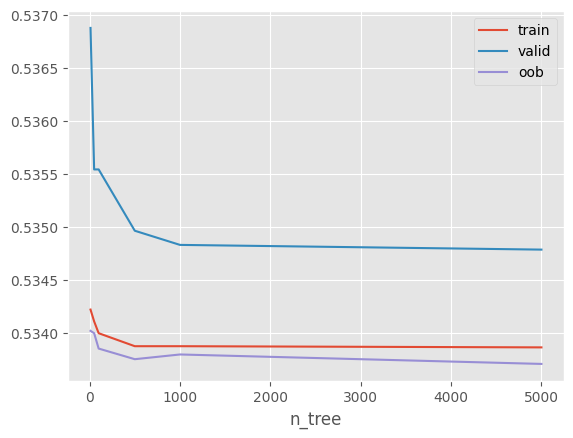

In [66]:
score_df.plot()
plt.legend(loc='best')

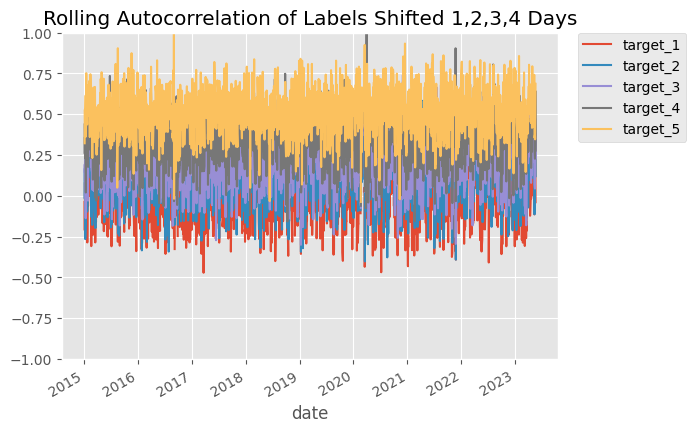

In [67]:
from scipy.stats import spearmanr

def sp(group, col1_name, col2_name):
    x = group[col1_name]
    y = group[col2_name]
    return spearmanr(x, y)[0]

all_factors = df.copy()
all_factors['target_1'] = all_factors.groupby(level=1)[return_col_name].shift(-5)
all_factors['target_2'] = all_factors.groupby(level=1)[return_col_name].shift(-4)
all_factors['target_3'] = all_factors.groupby(level=1)[return_col_name].shift(-3)
all_factors['target_4'] = all_factors.groupby(level=1)[return_col_name].shift(-2)
all_factors['target_5'] = all_factors.groupby(level=1)[return_col_name].shift(-1)

g = all_factors.dropna().groupby(level=0)
for i in range(5):
    label = 'target_'+str(i+1)
    ic = g.apply(sp, return_col_name, label)
    ic.plot(ylim=(-1, 1), label=label)
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.title('Rolling Autocorrelation of Labels Shifted 1,2,3,4 Days')
plt.show()

In [68]:
factors = ['rsi', 'bollinger_ratio', 'cv_ratio']
prob_array = np.array([-1, 1])
proba = clf.predict_proba(x_train)
alpha_score = proba.dot(prob_array)

In [87]:
alpha_score_label = 'AI_ALPHA'
factors_with_alpha = df.loc[x_train.index].copy()
factors_with_alpha[alpha_score_label] = alpha_score
selected_factor_df = factors_with_alpha[factors + [alpha_score_label]]
selected_factor_df.head(3)

,,rsi,bollinger_ratio,cv_ratio,AI_ALPHA
date,ticker,,,,
2015-01-05,AEONTS,35.714400,0.110593,0.000007,-0.039979
2015-01-06,AEONTS,33.333357,0.166329,0.000014,-0.045958
2015-01-07,AEONTS,25.000020,0.224731,0.000014,-0.045683


In [88]:
alpha_eval = AlphaFactorEvaluator(factor_return=selected_factor_df, price=close_df_pivot)
factor_data_dict = alpha_eval.combine_factor_forward_returns(period = 1, max_loss = 0.4, verbose = True)

Formatting factor data for rsi
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Formatting factor data for bollinger_ratio
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Formatting factor data for cv_ratio
Dropped 0.5% entries from factor data: 0.0% in forward returns computation and 0.5% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Formatting factor data for AI_ALPHA
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!


In [71]:
factor_return_df = alpha_eval.get_factor_returns(factor_data_dict)

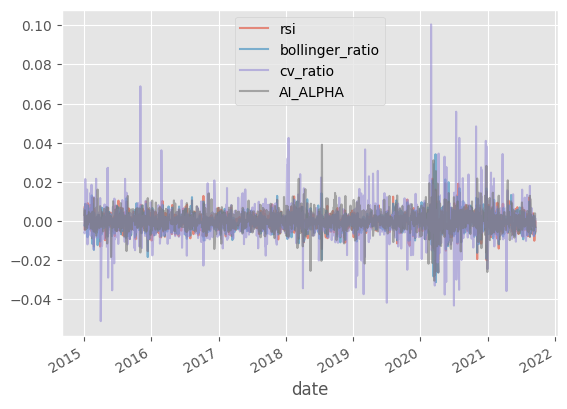

In [72]:
alpha = 0.6
factor_return_df.plot(alpha = alpha)
plt.legend()

Text(0.5, 1.0, 'compared with the AI generated')

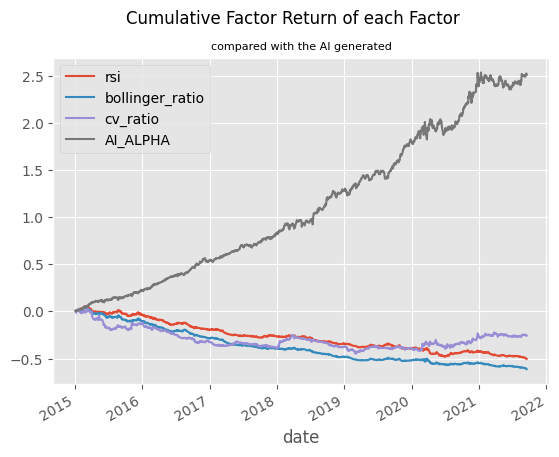

In [73]:
factor_return_df.add(1).cumprod().add(-1).plot()
plt.suptitle('Cumulative Factor Return of each Factor', size = 12)
plt.title('compared with the AI generated', size = 8)

<AxesSubplot: xlabel='date'>

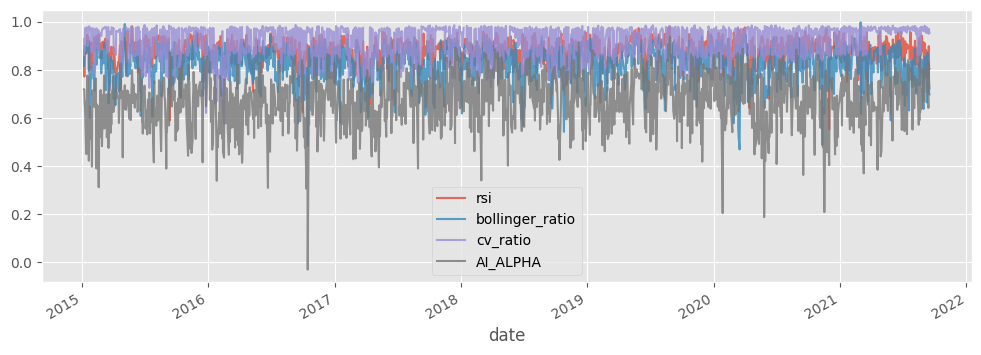

In [74]:
# Factor Rank Autocorrelation
rank_ac_df = alpha_eval.get_factor_rank_autocorrelation(factor_data_dict)
rank_ac_df.plot(alpha = 0.8, figsize = (12, 4))

In [75]:
# mean return by quantile
qt_return_df = alpha_eval.get_mean_return_by_quantile(factor_data_dict)

<AxesSubplot: xlabel='factor_quantile'>

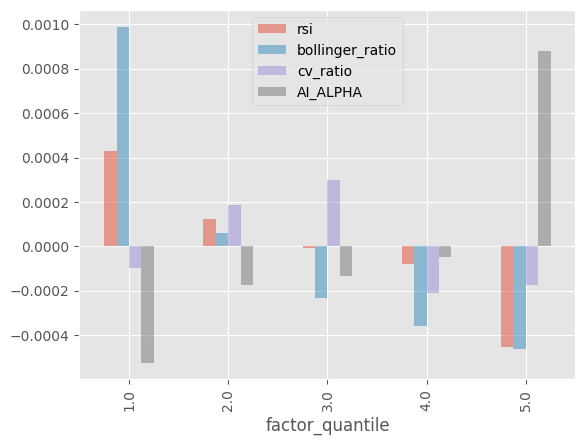

In [76]:
qt_return_df.plot(kind = 'bar', alpha = 0.5)

<h1 style="color:turquoise">Use No Overlap Voter to generate an AI-based Alpha Factor</h1>

In [15]:
n_stocks = len(sector_mapper_available)
n_days = len(x_train)

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': 100,
    'min_samples_split': 500,
    'max_depth': 2,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 42}
n_trees_l = [10, 50, 100, 500, 1000, 5000]

scores = []
feature_importances = []

for n_trees in n_trees_l:
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf_nov = NoOverlapClassifier(estimator = clf)
    clf_nov.fit(x_train, y_train)
    scores.append({
        'n_tree': n_trees,
        'train': clf_nov.score(x_train, y_train.values),
        'valid': clf_nov.score(x_test, y_test.values),
        'oob': clf_nov.oob_score_
    })

score_df = pd.DataFrame.from_dict(scores) \
            .set_index('n_tree')

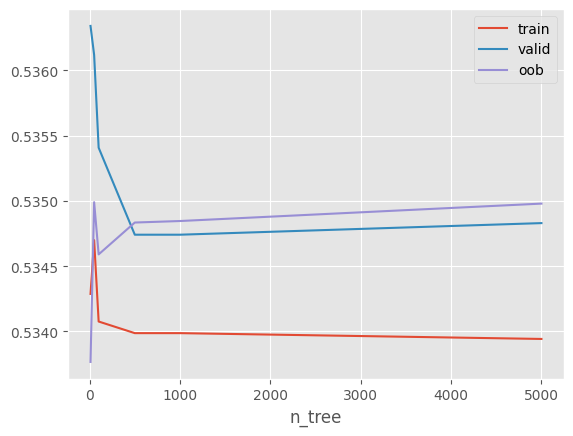

In [16]:
score_df.plot()
plt.legend(loc='best')

In [20]:
factors = ['rsi', 'bollinger_ratio', 'cv_ratio']
prob_array = np.array([-1, 1])
proba = clf_nov.predict_proba(x_train)
alpha_score = proba.dot(prob_array)

In [21]:
alpha_score_label = 'AI_ALPHA'
factors_with_alpha = df.loc[x_train.index].copy()
factors_with_alpha[alpha_score_label] = alpha_score
selected_factor_df = factors_with_alpha[factors + [alpha_score_label]]
selected_factor_df.head(3)

,,rsi,bollinger_ratio,cv_ratio,AI_ALPHA
date,ticker,,,,
2015-01-05,AEONTS,35.714400,-0.110593,0.000007,-0.040016
2015-01-06,AEONTS,33.333357,-0.166329,0.000014,-0.045902
2015-01-07,AEONTS,25.000020,-0.224731,0.000014,-0.045682


In [22]:
alpha_eval = AlphaFactorEvaluator(factor_return=selected_factor_df, price=close_df_pivot)
factor_data_dict = alpha_eval.combine_factor_forward_returns(period = 1, max_loss = 0.4, verbose = True)

Formatting factor data for rsi
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Formatting factor data for bollinger_ratio
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Formatting factor data for cv_ratio
Dropped 0.5% entries from factor data: 0.0% in forward returns computation and 0.5% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Formatting factor data for AI_ALPHA
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!


In [23]:
factor_return_df = alpha_eval.get_factor_returns(factor_data_dict)

Text(0.5, 1.0, 'compared with the AI generated')

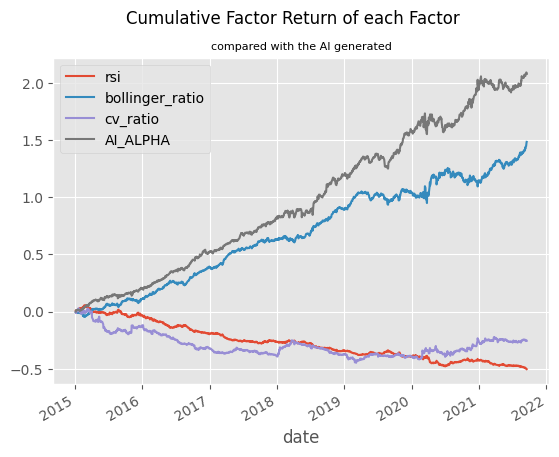

In [24]:
factor_return_df.add(1).cumprod().add(-1).plot()
plt.suptitle('Cumulative Factor Return of each Factor', size = 12)
plt.title('compared with the AI generated', size = 8)

In [25]:
# mean return by quantile
qt_return_df = alpha_eval.get_mean_return_by_quantile(factor_data_dict)

<AxesSubplot: xlabel='factor_quantile'>

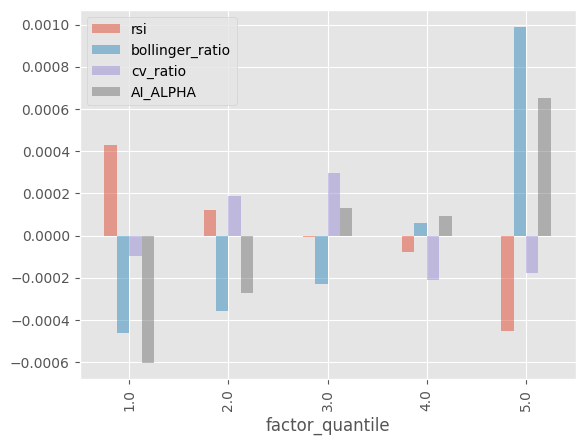

In [26]:
qt_return_df.plot(kind = 'bar', alpha = 0.5)